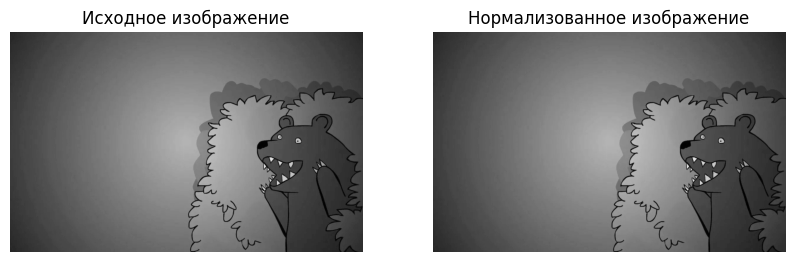

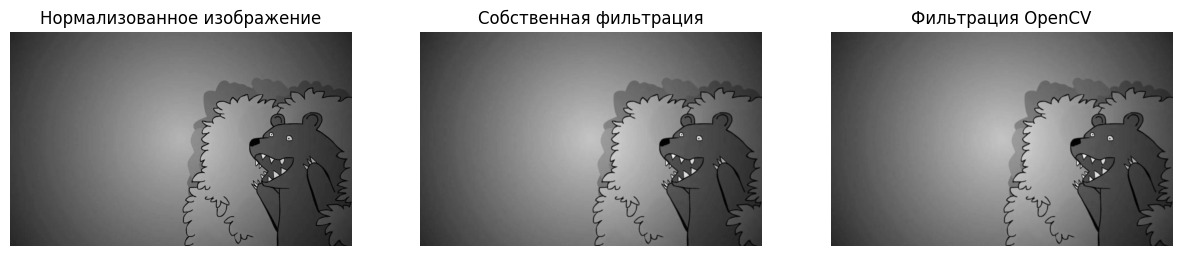

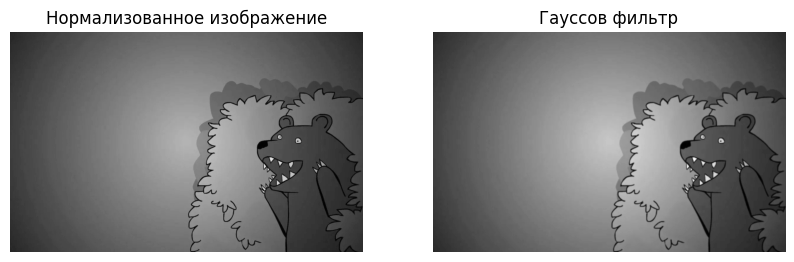

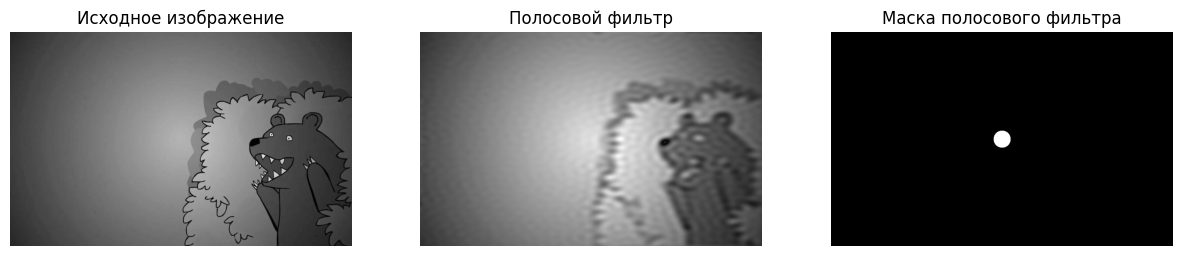

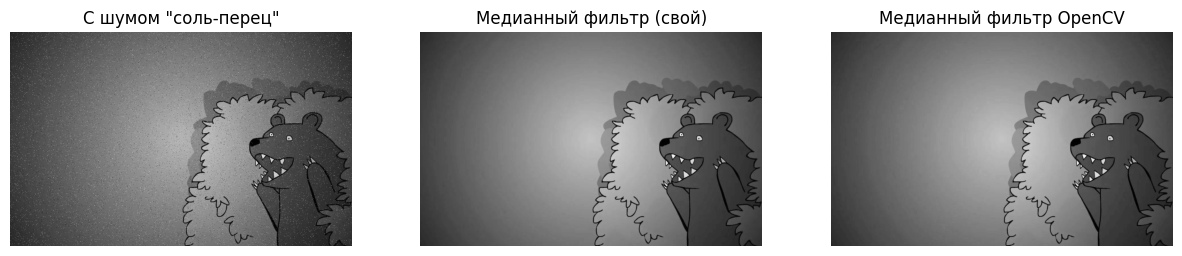

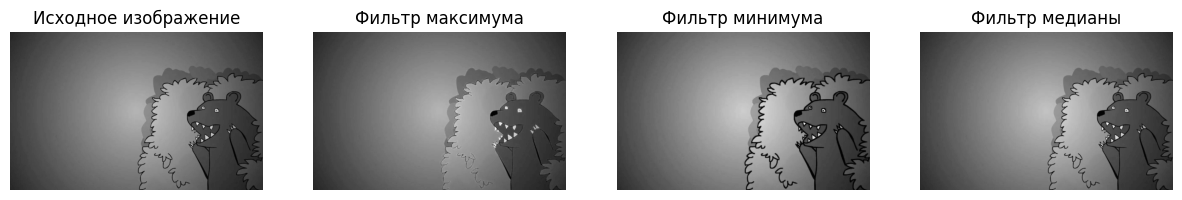

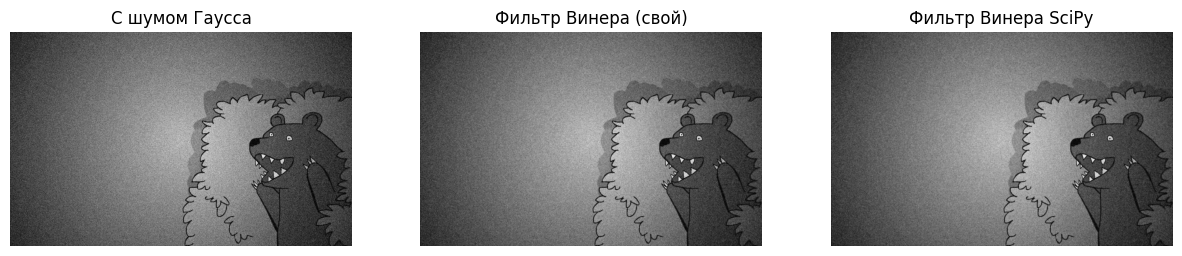

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузка изображения
image = cv2.imread('img.png', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Изображение не найдено или не может быть загружено.")

# Нормализация изображения (приведение значений пикселей к диапазону [0, 1])
normalized_image = cv2.normalize(image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

# Отображение исходного и нормализованного изображений
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Исходное изображение')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Нормализованное изображение')
plt.imshow(normalized_image, cmap='gray')
plt.axis('off')

plt.show()



def custom_filter(image, kernel):
    """Применение масочной фильтрации вручную."""
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), 'reflect')
    filtered_image = np.zeros_like(image, dtype=np.float32)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kh, j:j+kw]
            filtered_value = np.sum(region * kernel)
            filtered_image[i, j] = filtered_value
    return filtered_image

# Пример маски: среднее размытие
kernel = np.ones((3,3), dtype=np.float32) / 9.0

# Применение собственной фильтрации
filtered_custom = custom_filter(normalized_image, kernel)

# Применение фильтра OpenCV
filtered_opencv = cv2.filter2D(normalized_image, -1, kernel)

# Отображение результатов
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Нормализованное изображение')
plt.imshow(normalized_image, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Собственная фильтрация')
plt.imshow(filtered_custom, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Фильтрация OpenCV')
plt.imshow(filtered_opencv, cmap='gray')
plt.axis('off')

plt.show()



# Применение гауссового фильтра (низкочастотный)
gaussian_blur = cv2.GaussianBlur(normalized_image, (5,5), 0)

# Отображение результатов
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Нормализованное изображение')
plt.imshow(normalized_image, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Гауссов фильтр')
plt.imshow(gaussian_blur, cmap='gray')
plt.axis('off')

plt.show()




# Преобразование Фурье
f = np.fft.fft2(normalized_image)
fshift = np.fft.fftshift(f)

# Создание маски для полосового фильтра
rows, cols = normalized_image.shape
crow, ccol = rows // 2, cols // 2
radius = 30
mask = np.zeros((rows, cols), np.uint8)
cv2.circle(mask, (ccol, crow), radius, 1, thickness=-1)

# Применение маски
fshift_filtered = fshift * mask

# Обратное преобразование
f_ishift = np.fft.ifftshift(fshift_filtered)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

# Отображение результатов
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Исходное изображение')
plt.imshow(normalized_image, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Полосовой фильтр')
plt.imshow(img_back, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Маска полосового фильтра')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.show()



def add_salt_pepper_noise(image, amount=0.005):
    """Добавление шума 'соль-перец'."""
    noisy = image.copy()
    num_salt = np.ceil(amount * image.size * 0.5).astype(int)
    num_pepper = np.ceil(amount * image.size * 0.5).astype(int)
    
    # Добавление соли (белых пикселей)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy[coords[0], coords[1]] = 1.0
    
    # Добавление перца (черных пикселей)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy[coords[0], coords[1]] = 0.0
    
    return noisy

# Добавление шума
noisy_image = add_salt_pepper_noise(normalized_image, amount=0.02)

# Применение медианного фильтра вручную
def custom_median_filter(image, kernel_size=3):
    pad = kernel_size // 2
    padded_image = np.pad(image, pad, 'reflect')
    filtered_image = np.zeros_like(image)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            median = np.median(region)
            filtered_image[i, j] = median
    return filtered_image

filtered_median_custom = custom_median_filter(noisy_image, kernel_size=3)

# Применение медианного фильтра OpenCV
filtered_median_opencv = cv2.medianBlur((noisy_image * 255).astype(np.uint8), 3) / 255.0

# Отображение результатов
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('С шумом "соль-перец"')
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Медианный фильтр (свой)')
plt.imshow(filtered_median_custom, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Медианный фильтр OpenCV')
plt.imshow(filtered_median_opencv, cmap='gray')
plt.axis('off')

plt.show()




def custom_rank_filter(image, kernel_size=3, rank=0):
    """Ранговый фильтр. rank=0 - минимум, rank=-1 - медиана, rank=-k - максимум."""
    pad = kernel_size // 2
    padded_image = np.pad(image, pad, 'reflect')
    filtered_image = np.zeros_like(image)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            sorted_vals = np.sort(region, axis=None)
            if rank == -1:
                value = sorted_vals[-1]
            elif rank == 0:
                value = sorted_vals[0]
            else:
                value = sorted_vals[rank]
            filtered_image[i, j] = value
    return filtered_image

# Применение фильтра максимума
filtered_max = custom_rank_filter(normalized_image, kernel_size=3, rank=-1)

# Применение фильтра минимума
filtered_min = custom_rank_filter(normalized_image, kernel_size=3, rank=0)

# Применение медианного фильтра
filtered_median = custom_rank_filter(normalized_image, kernel_size=3, rank=- (3*3)//2 )

# Отображение результатов
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.title('Исходное изображение')
plt.imshow(normalized_image, cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title('Фильтр максимума')
plt.imshow(filtered_max, cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title('Фильтр минимума')
plt.imshow(filtered_min, cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.title('Фильтр медианы')
plt.imshow(filtered_median, cmap='gray')
plt.axis('off')

plt.show()




from scipy.signal import wiener

def add_gaussian_noise(image, mean=0, var=0.01):
    """Добавление гауссовского белого шума."""
    sigma = np.sqrt(var)
    gauss = np.random.normal(mean, sigma, image.shape)
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 1)
    return noisy

# Добавление гауссовского шума
noisy_gaussian = add_gaussian_noise(normalized_image, mean=0, var=0.01)

# Реализация адаптивного фильтра Винера вручную
def custom_wiener_filter(image, kernel_size=3, noise_var=0.01):
    """Адаптивный фильтр Винера."""
    pad = kernel_size // 2
    padded_image = np.pad(image, pad, 'reflect')
    filtered_image = np.zeros_like(image)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            local_mean = np.mean(region)
            local_var = np.var(region)
            # Вычисление коэффициента Винера
            if local_var > noise_var:
                w = local_var / (local_var + noise_var)
            else:
                w = 0
            filtered_image[i, j] = local_mean + w * (image[i, j] - local_mean)
    return filtered_image

filtered_wiener_custom = custom_wiener_filter(noisy_gaussian, kernel_size=3, noise_var=0.01)

# Применение фильтра Винера из scipy
filtered_wiener_scipy = wiener(noisy_gaussian, (3,3), noise=0.01)

# Отображение результатов
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('С шумом Гаусса')
plt.imshow(noisy_gaussian, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Фильтр Винера (свой)')
plt.imshow(filtered_wiener_custom, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Фильтр Винера SciPy')
plt.imshow(filtered_wiener_scipy, cmap='gray')
plt.axis('off')

plt.show()